## 卷积网络中所需要的模块
1. 卷积模块，包含以下函数：
 * 使用０扩充边界
 * 卷积窗口
 * 前向卷积
 * 反向卷积（可选）
2. 池化模块，包含以下函数：
 * 前向池化
 * 创建掩码
 * 值分配
 * 反向池化（可选）

## 边界填充 
**边界填充的实现**  
可以使用numpy中的pad函数来对矩阵进行边界填充  
np.pad(arr, ((dim1_before, dim1_after), (dim2_before, dim2_after),...), 'constant')  
其中：
1. arr表示需要进行填充的矩阵
2. ((dim1_before, dim1_after), (dim2_before, dim2_after),...)表示每一维前后填充的宽度
3. 'constant'表示用常数进行填充，默认为 0 进行填充　　

**边界填充的好处**  
* 经过边界填充之后，可以使卷积层的输出保持大小不变。这对于建立较深层的神经网络十分重要。
* 边界填充可以帮助我们保留更多的信息，在没有填充的情况下，卷积过程中图像边缘的极少数值会受到过滤器的影响从而导致信息丢失。

In [15]:
import numpy as np
arr3D = np.array([[[1,2,3,4,5],
                   [1,2,32,4,5],
                   [1,2,3,4,54]],
                  [[2,3,4,4,5],
                   [2,3,3,4,5],
                   [2,3,4,4,5]]])
print(np.pad(arr3D, ((0,0),(1,1),(2,2)), 'constant'))
arr1 = np.array([[1,2,3],
                 [2,3,4]])
print(np.pad(arr1, ((0,1),(2,2)), 'constant'))


[[[ 0  0  0  0  0  0  0  0  0]
  [ 0  0  1  2  3  4  5  0  0]
  [ 0  0  1  2 32  4  5  0  0]
  [ 0  0  1  2  3  4 54  0  0]
  [ 0  0  0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0  0  0]
  [ 0  0  2  3  4  4  5  0  0]
  [ 0  0  2  3  3  4  5  0  0]
  [ 0  0  2  3  4  4  5  0  0]
  [ 0  0  0  0  0  0  0  0  0]]]
[[0 0 1 2 3 0 0]
 [0 0 2 3 4 0 0]
 [0 0 0 0 0 0 0]]


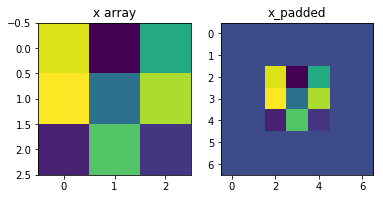

In [24]:
%matplotlib inline
# 定义0填充函数
def zero_pad(x, pad):
    """
    parameters:
    @ x: 图像数据集，维度为（样本数，图像高度，图像宽度，图像通道数）
    @ pad: 整数，对图像数据集中每个样本的每一个通道（即R,G,B层）进行填充
    
    return:
    @ x_padded: 经过填充之后的图像数据集
    """
    
    x_padded = np.pad(x, ((0,0),       # 第一维表示样本数，不填充
                          (pad,pad),   # 图像高度，(x,y)可以视为上面填充ｘ个，下面填充ｙ个
                          (pad,pad),   # 图像宽度，(x,y)可以视为左边填充ｘ个，右边填充ｙ个
                          (0,0)),      # 通道数，不填充
                      'constant', constant_values=0)  # 使用连续一样的值进行填充
    return x_padded

# 测试一下
import matplotlib.pyplot as plt

np.random.seed(1)
x = np.random.randn(1,3,3,2)
x_padded = zero_pad(x, pad=2)
fig, axeses = plt.subplots(1,2)
axeses[0].set_title('x array')
axeses[0].imshow(x[0,:,:,0])
axeses[1].set_title('x_padded')
axeses[1].imshow(x_padded[0,:,:,0])

---
## 卷积神经网络的前向传播
**单步卷积**

In [35]:
def conv_single_step(slice_prev, w, b):
    """
    parameters:
    @ slice_prev: 输入数据的一个片段，截取自前一层网络的输出，维数为（滤波器大小，滤波器大小，输入数据通道数）
    @ w: 权重参数，包含在一个矩阵中，维数与 slice_prev 一致（也可以通道数为１，表示对slice_prev的所有通道执行相同卷积）
    @ b: 偏置参数，维数为 (1,1,1)
    
    return:
    @ z: 单步卷积的计算结果
    """
    a = np.multiply(slice_prev, w) + b
    z = np.sum(a)
    return z
x = np.random.randn(3,3,2)
w = np.random.randn(3,3,1)
b = 1
print(conv_single_step(x, w, b))

17.628990515459734


**前向传播（卷积层）**  
在前向传播的过程中，在每一个卷积层中，我们将使用多种卷积核对输入的数据进行卷积操作，使用每个卷积核进行卷积之后都会产生一个2D的矩阵，将这些2D的矩阵堆叠起来就变成了三维的矩阵，卷积核的个数对应该矩阵的通道数。  

卷积输出的维度计算：
\begin{equation}
n_{H_{out}}=\lfloor \frac {n_{H_{in}}-f+2\times p}{stride}\rfloor +1\\
n_{W_{out}}=\lfloor \frac {n_{W_{in}}-f+2\times p}{stride}\rfloor +1\\
n_c=卷积核数目
\end{equation}
$n_{H}$为图像数据的高  
$n_{W}$为图像数据的宽  
$stride$为卷积步长  

In [39]:
# 前向传播中卷积层的实现
def conv_forward(x_input, w, b, **kwargs):
    """
    parameters:
    @ x_input: 神经网络中上一层的输出矩阵，维度为（m,n_H_prev,n_W_prev,n_C_prev）
               m -> 样本容量
               n_H_prev -> 图片高度
               n_W_prev -> 图片宽度
               n_C_prev -> 通道数
    @ w: 权重矩阵，维度为（n_C,f,f,n_C_prev）
         f        -> 卷积核大小
         n_C_prev -> 上一层输出的通道数
         n_C      -> 该层卷积核的数目
    @ b: 偏置矩阵，维度为（n_C, 1）,每个卷积核有一个偏置矩阵
    @ kwargs: 可以传入参数 stride 和参数 pad，分别表示卷积的步长和边缘填充的数目
    
    return: 
    @ z_array: 卷积输出，维度为（m,n_H,n_W,n_C）
               m: 样本数
               n_H: 输出图像的高度
               n_W: 输出图像的宽度
               n_C: 卷积核的数目（输出图像的通道数）
    @ cache: 缓存一些卷积层的反向传播计算需要的数据
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = x_input.shape
    (n_C, f, f, n_C_prev) = w.shape
    
    stride = 1
    pad = 0
    if 'stride' in kwargs:
        stride = kwargs['stride']
    if 'pad' in kwargs:
        pad = kwargs['pad']

    n_H = (n_H_prev - f + 2 * pad) // stride + 1
    n_W = (n_W_prev - f + 2 * pad) // stride + 1
    
    y_output = np.zeros((m, n_H, n_W, n_C))   # 初始化卷积结果的存储矩阵
    
    x_input_padded = zero_pad(x_input, pad)  # 对输入的矩阵进行0填充
    
    for i in range(m):                  # 对每个样本
        x = x_input_padded[i]
        for h in range(n_H):            # 对每个样本的每一行
            for w in range(n_W):        # 对每个样本的每一列
                for c in range(n_C):    # 对每一个通道
                    vert_start = stride * h
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    slice_prev = x[vert_start:vert_end, horiz_start:horiz_end, :]
                    y_output[i, h, w, c] = conv_single_step(slice_prev, w[c,:,:,:])
                    # 如果有激活函数，在这一步将 y_output[i,h,w,c]　传入激活函数
    
    cache = (x_input, w, b, stride, pad)
    return (y_output, cache)


**前向传播（池化层）**  
池化层会减少输入的宽度和高度，这样，在减少计算量的同时也使得特征检测器对其在输入中的位置更加稳定。
1. 最大值池化层：在输入矩阵中滑动一个大小为 f×f 的窗口，选取窗口中的最大值，然后作为输出的一部分
2. 均值池化层：在输入矩阵中滑动一个大小为 f×f 的窗口，计算窗口中的平均值，作为输出的一部分  

池化层输出维度计算：
\begin{equation}
n_H=\lfloor \frac {n_{H_{prev}}-f}{stride} \rfloor + 1\\
n_W=\lfloor \frac {n_{W_{prev}}-f}{stride} \rfloor + 1\\
n_C = n_{C_{prev}}\ ，通道数不变
\end{equation}


In [41]:
def pool_forward(x_input, mode = 'max', **kwargs):
    """
    parameters:
    @ x_input: 神经网络中上一层的输出矩阵，维度为（m,n_H_prev,n_W_prev,n_C_prev）
               m -> 样本容量
               n_H_prev -> 图片高度
               n_W_prev -> 图片宽度
               n_C_prev -> 通道数
    @ kwargs: 可以传入 f,stride 分别表示池化层的大小以及滑动窗口的步长
    @ mode: 表示池化的类型｛'max','mean'｝
    
    return:
    @ y_output: 池化层的输出，维度为（m, n_H, n_W, n_C）
    @ cache: 反向传播中需要用到的值
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = x_input.shape
    f = 2
    stride = 2
    if 'f' in kwargs: f = kwargs['f']
    if 'stride' in kwargs: stride = kwargs['stride']
    
    n_H = (n_H_prev - f) // stride + 1
    n_W = (n_W_prev - f) // stride + 1
    n_C = n_C_prev
    
    y_output = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    # 每一个样本的每一个通道分别进行操作
                    slice_prev = x_input[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if 'max' == mode.lower():
                        y_output[i, j, w, c] = np.max(slice_prev)
                    elif 'mean' == mode.lower():
                        y_output[i, j, w, c] = np.mean(slice_prev)
    cache = (x_input, mode, f, stride)
    return (y_output, cache)

---
## 卷积神经网络中的反向传播
在现在的深度学习框架中，只需要实现前向传播，框架负责反向传播的计算。
在全连接网络中，我们通过计算成本函数的梯度来进行参数的更新，类似的，在卷积神经网络中，我们也可以通过计算出成本的导数来更新参数。

### 池化层的反向传播
因为下采样层的存在，采样层（池化层）的一个像素对应卷积层输出的一块像素区域（采样区域）。所以为了在反向传播中能够计算卷积层的敏感度，就必须先对下采样（池化层）的敏感度（$dz^{[l+1]}$）进行上采样，使其与卷积层的map的尺寸对应。  

\begin{equation}
\delta^{[l]}=up(\delta^{[l+1]})* A^{[l]'}(z)
\end{equation}
$[l+1]$为池化层，$[l]$为卷积层,　$up(\delta^{[l+1]})$ 为对 $[l+1]$ 层敏感度的上采样，上采样的公式为：
\begin{equation}
mask * \delta^{[l+1]}
\end{equation}
**对于池化层的反向传播而言，有以下两种情况：**  
**1. 均值池化层（池化层的维度为n\*n）** 
\begin{equation}
mask = \frac {1}{n\times n}
\left[
\begin{array}{cccc}
1 & 1 & \cdots & 1 \\
1 & 1 & \cdots & 1 \\
\vdots & \vdots & \ddots & \vdots \\
1 & 1 & \cdots & 1
\end{array}
\right]
\end{equation}
**2. 最大值池化层**
\begin{equation}
mask = 只有最大值所在的对应位置为１，其余位置为０的n\times n　矩阵
\end{equation}

In [1]:
import numpy as np

def get_mask(x, mode):
    m_h, m_w = x.shape
    if 'mean' == mode.lower():
        mask = np.ones((m_h, m_w)) / (m_h * m_w)
    elif 'max' == mode.lower():
        mask = x == np.max(x)
    return mask

# 定义池化层的反向传播
def back_propagation_pool(dz, cache):
    """
    parameters:
    @ dz: 池化层的敏感度，与池化层输出的维度一致
    @ cache: 在池化层前向传播过程中所存储的参数
             x_input：池化层的输入矩阵，即卷积层的输出 A_prev
             mode: 池化层的模式
             f: 池化层大小
             stride: 池化步长
    
    return:
    @ dA_prev: 池化层反向传播的输出，与 x_input 的尺寸一致
    """
    
    x_input, mode, f, stride = cache
    m, n_H_prev, n_W_prev, n_C_prev = x_input.shape
    m, n_H, n_W, n_C = dz.shape
    dA_prev = np.zeros_like(x_input, dtype = 'float64')
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    slice_prev = x_input[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    mask = get_mask(slice_prev, mode)
                    dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]\
                        += np.multiply(mask, dz[i, h, w, c])
    return dA_prev

# 测试一下
dz = np.array([[[[2],[3]],[[4],[5]]]])
x_input = np.array([[[[1], [2], [3], [2]],
                     [[2], [1], [1], [2]],
                     [[1], [2], [4], [3]],
                     [[3], [4], [5], [1]]]])
mode = 'mean'
f = 2
stride = 2
cache = (x_input, mode, f, stride)
back_propagation_pool(dz, cache)

array([[[[0.5 ],
         [0.5 ],
         [0.75],
         [0.75]],

        [[0.5 ],
         [0.5 ],
         [0.75],
         [0.75]],

        [[1.  ],
         [1.  ],
         [1.25],
         [1.25]],

        [[1.  ],
         [1.  ],
         [1.25],
         [1.25]]]])

### 卷积层的反向传播
我们假定每个卷积层ｌ都会接一个下采样层ｌ＋１。对于bp网络来说，要求得层ｌ的每个神经元对应的权值的权值更新，就需要先求得层ｌ的每一个神经元对应的敏感度$\delta$（即全连接网络中的$\frac {d_{cost}}{d_z}$），而根据bp的反向传播公式 $dA^{[l-1]}=\omega^{[l]T}\frac {d_{lose}}{d_{z^{[l]}}}$，要求该层的敏感度，就必须先求下一层的敏感度，然后乘以权值矩阵。  
对于卷积层而言，卷积层的下一层为池化层，池化层的反向传播敏感度经过上采样之后得到的敏感度 $\delta^{[l]}$ 即为卷积层反向传播的输入。卷积层求解反向传播的公式与 DNN 中的公式类似，唯一的区别是 DNN 中的权重矩阵 $\omega$ 对应于卷积层中的卷积核，并且在反向传播时需要对卷积核进行 $180^o$ 翻转(先上下翻转，后左右翻转)。  

**关于卷积层反向传播的推演**  
假设 $l-1$ 层的输出 $a^{[l-1]}$ 是一个 $3\times 3$ 矩阵，第 $l$ 层的卷积核 $\omega^{[l]}$ 是一个 $2 \times 2$ 矩阵，采用１像素的步幅，则输出 $z^{[l]}$ 是一个 $2\times 2$ 矩阵，我们简化 $b^l$ 都是０，则有：
\begin{equation}
a^{[l-1]}*\omega^{[l]}=z^{[l]}\qquad (1)
\end{equation}
列出 $a,\omega,z$ 的矩阵表达式如下：
\begin{equation}
\left[
\begin{array}{ccc}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
a_{31} & a_{32} & a_{33}
\end{array}
\right]
*
\left[
\begin{array}{cc}
\omega_{11} & \omega_{12}\\
\omega_{21} & \omega_{22}
\end{array}
\right]
=
\left[
\begin{array}{cc}
z_{11} & z_{12}\\
z_{21} & z_{22}
\end{array}
\right]\qquad (2)
\end{equation}

利用卷积的定义，很容易得出：
\begin{equation}
\begin{array}{c}
z_{11}=a_{11}\omega_{11}+a_{12}\omega_{12}+a_{21}\omega_{21}+a_{22}\omega_{22}\\
z_{12}=a_{12}\omega_{12}+a_{13}\omega_{13}+a_{22}\omega_{22}+a_{23}\omega_{23}\\
\cdots
\end{array}   \qquad (3)
\end{equation}

接着模拟反向求导的过程(在反向传播过程中从当前层传入前一层的矩阵$\nabla a^{[l-1]}$)：
\begin{equation}
\nabla{a^{[l-1]}}=\frac {\partial{J(\omega,b)}}{\partial{a^{[l-1]}}}=\frac {\partial{J(\omega,b)}}{z^{[l]}} \frac {\partial{z^{[l]}}}{\partial{a^{[l-1]}}}=\delta^{[l]} \frac {\partial{z^{[l]}}}{\partial{a^{[l-1]}}} \qquad (4)
\end{equation}

从上面式子可以看出，对于 $a^{[l-1]}$ 的梯度误差 $\nabla a^{[l-1]}$，等于第 $l$ 层的敏感度($\delta^{l}$)乘以 $\frac {\partial z^{[l]}}{\partial a^{[l-1]}}$　，而 $\frac {\partial z^{[l]}}{\partial a^{[l-1]}}$ 对应于上面的例子中相关联的 $\omega$ 的值。假设我们的 $z$ 矩阵对应的反向传播误差是 $\delta_{11},\delta_{12},\delta_{21},\delta_{22}$ ，则利用上面式(4)中卷积计算的几个等式，可以分别写出 $\nabla a^{[l-1]}$ 的９个标量的梯度。  
比如对于 $a_{11}$ 的梯度，由于在４个等式中 $a_{11}$ 只和 $z_{11}$ 有乘积关系，有：  
$$\nabla a_{11} = \delta_{11}\omega_{11}$$
对于 $a_{12}$ 的梯度，在４个等式中，只和 $z_{11},z_{12}$ 有乘积关系，从而有：
$$\nabla a_{12} = \delta_{11}\omega_{12} + \delta_{12}\omega_{11}$$
对于其余几项，分别有：
\begin{equation}
\nabla a_{13}=\delta_{12}\omega_{12}\\
\nabla a_{21}=\delta_{11}\omega_{21}+\delta_{21}\omega_{11}\\
\nabla a_{22}=\delta_{11}\omega_{22}+\delta_{12}\omega_{21}+\delta_{21}\omega_{12}+\delta_{22}\omega_{11}\\
\nabla a_{23}=\delta_{12}\omega_{22}+\delta_{22}\omega_{12}\\
\nabla a_{31}=\delta_{21}\omega_{21}\\
\nabla a_{32}=\delta_{21}\omega_{22}+\delta_{22}\omega_{21}\\
\nabla a_{33}=\delta_{22}\omega_{22}
\end{equation}
上述９个式子其实可以用一个矩阵卷积的形式表示，即：
\begin{equation}
\left[
\begin{array}{cccc}
0 & 0 & 0 & 0 \\
0 & \delta_{11} & \delta_{12} & 0 \\
0 & \delta_{21} & \delta_{22} & 0 \\
0 & 0 & 0 & 0
\end{array}
\right]
*
\left[
\begin{array}{cc}
\omega_{22} & \omega_{21} \\
\omega_{12} & \omega_{11}
\end{array}
\right]
=
\left[
\begin{array}{ccc}
a_{11} & a_{12} & a_{13}\\
a_{21} & a_{22} & a_{23}\\
a_{31} & a_{32} & a_{33}
\end{array}
\right]
\end{equation}

**推导卷积层w，b的梯度**  
根据上述的推演，就已经可以计算出卷积层反向传播的输出 $\delta{[l-1]}$ 作为上一层反向传播的输入了，但是卷积层相比与池化层而言，还多了两个参数：卷积核 w 以及偏差 b，类似与 DNN 中的权重矩阵 w 以及偏差 b，需要在反向传播的过程中通过梯度下降进行更新。  
注意到卷积层 $z^{[l]}$ 和 $w^{[l]}$ 以及 $b^{[l]} 的关系，有：  

$$z^{[l]}=w^{[l]}*a^{[l-1]}+b^{[l]}\ , 此处的 * 表示卷积操作$$  
因此，当计算 w 的梯度时，有以下操作：  
\begin{equation}
\frac {\partial{cost}}{\partial{w^{[l]}}}=a^{[l-1]}*\delta^{[l]}, \ 此处的 * 也表示卷积操作
\end{equation}
